# Anomaly Detection in Time Series Data
###### July 2016

This notebook documents a series of experiments in anomaly detection on a time-series of measurements from a municipal water tank. It is inspired by the techniques described in [*Practical Machine Learning: A New Look at Anomaly Detection*](http://shop.oreilly.com/product/0636920034650.do) by Ted Dunning and Ellen Friedman, and realized in Python by [*Matthew Rahtz*](http://amid.fish/anomaly-detection-with-k-means-clustering).

## Problem Definition

Suppose we have instrumented a municipal water tank with a pressure sensor which we use to determine water levels in the tank (which in fact we have *actually* done). Over time, we should observe the water tank alternately emptying and filling. Let's take a look at what this may look like: 

In [1]:
# load libraries and set plot parameters
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

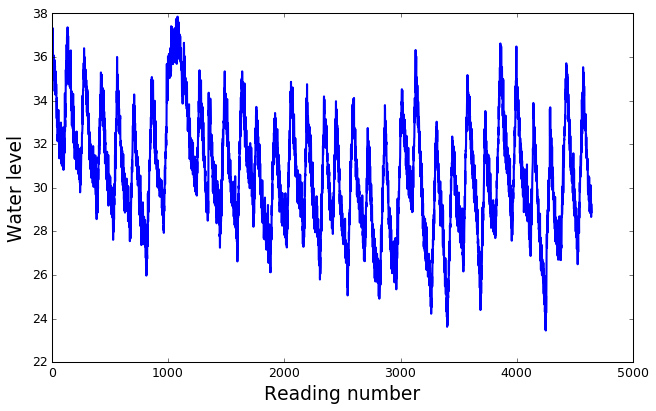

In [2]:
data = open('watertank_data.csv').readlines()
points = [float(p.strip()) for p in data]
all_data = np.array(points)
# lets take half of the input data for training, and half for testing
# and create numpy arrays
half = int(len(points)/2)
train_data = all_data[:half]
test = all_data[half:]

#plt.figure(figsize=(16, 10))
plt.plot(train_data)
plt.xlabel("Reading number")
plt.ylabel("Water level")

We will want the data to be centered on zero, which the scale method from Scikit-Learn will do for us:

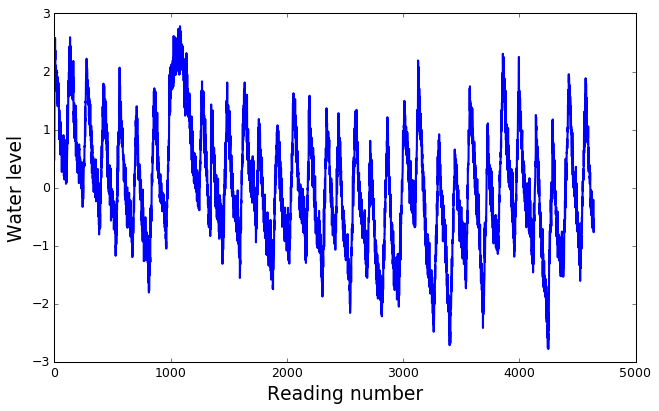

In [3]:
# np.amin and np.amax returns the minimum/maximum values in an array
from sklearn import preprocessing
train = preprocessing.scale(np.copy(train_data))
plt.plot(train)
plt.xlabel("Reading number")
plt.ylabel("Water level")

That's better!

## Clustering

We are now going to use a technique from machine learning called *clustering* to develop a collection of "typical" signal shpes from the data. We will use this collection of typical signal shapes to reconstruct an expected time series against which we will compare the test data. Test data that deviate from the expected data will be flagged as anomylous.

Let us deviate from the problem for a discussion of how clustering works.  In the example below, you can see that the data points group into two clusters, where each data point is represented by (x,y) coordinates in a 2-dimensional space. Then we determine the [centroid](https://en.wikipedia.org/wiki/Centroid) of each cluster; they appear where the red circles are in the example. These are the "typical" or "expected" value for each cluster.


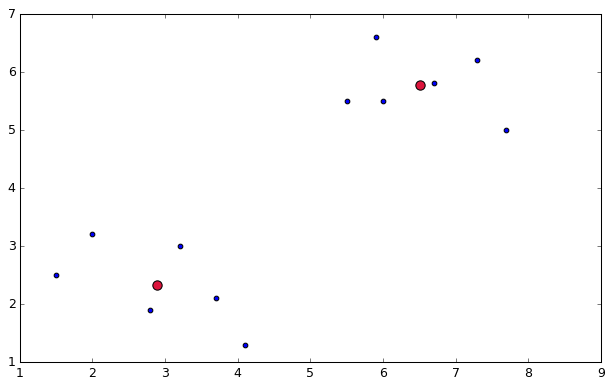

In [4]:
data2d = open('2d.csv').readlines()
xdata = []
ydata = []
for line in data2d:
    x,y = line.strip().split(',')
    xdata.append(x)
    ydata.append(y)
    
plt.scatter(x=xdata,y=ydata)

# calculate and plot the cluster centroids
zipped = zip(xdata, ydata)
coords = [[a,b] for a,b in zipped]
num_clusters = 2
clusterer = KMeans(n_clusters=num_clusters)
clusterer.fit(coords)
centers_x = [l[0] for l in clusterer.cluster_centers_]
centers_y = [l[1] for l in clusterer.cluster_centers_]

plt.scatter(centers_x, centers_y, marker='o', c='crimson', s=80)
plt.show()

We can do the same thing in three dimensions, where each point is represented by (x,y,z) coordinates in a 3-dimensional space. Here we see two clusters in 3-dimensional space (centroids in blue).

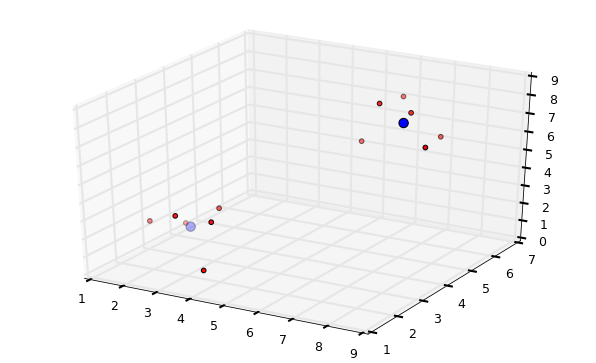

In [5]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
plt3d = fig.add_subplot(111, projection='3d')
xdata = []
ydata = []
zdata = []
coords = []
lines = open('3d.csv').readlines()
for line in lines:
    x,y,z = line.strip().split(',')
    coords.append([x,y,z])
    xdata.append(float(x))
    ydata.append(float(y))
    zdata.append(float(z))
    
plt3d.scatter(xdata, ydata, zdata, c='r', marker='o')

num_clusters = 2
clusterer = KMeans(n_clusters=num_clusters)
clusterer.fit(coords)
centers_x = [l[0] for l in clusterer.cluster_centers_]
centers_y = [l[1] for l in clusterer.cluster_centers_]
centers_z = [l[2] for l in clusterer.cluster_centers_]

plt3d.scatter(centers_x, centers_y, centers_z, marker='o', c='blue', s=80)

plt.show()



In the case of clustering our time-series data, we are going to take samples of 90 sequential points which we will treat as coordinates of points in high-dimensional, 90-D space. Each point is represented by a set of 90 coordinates which has the effect of mapping a segment of the time-series signal onto a single point in 90-dimensional space. Applying clustering to these samples will result in a collection of centriods which represent "typical" segments we would expect in our data.

## Segmenting

To produce samples of our time-series data for clustering, we will capture overlapping segments of 90 data points at a time, moving 9 samples along the time-series for each subsequent sample. This should result in a good variety of segment shapes to supply to the clustering step.

In [6]:
# based on https://github.com/mrahtz/sanger-machine-learning-workshop/blob/master/learn_utils.py
def segment(data, segment_len, step_size):
    segments = []

    for start in range(0, len(data), step_size):
        end = start + segment_len
        segment = np.copy(data[start:end])
        # if the final segment is shorter than our segment length, discard it
        if len(segment) != segment_len:
            continue
        segments.append(segment)

    return segments

segments = segment(train, 90, 9)

Let's take a look at what some of the resulting segments look like. We'll define a method that plots a 4x4 matrix of plots:

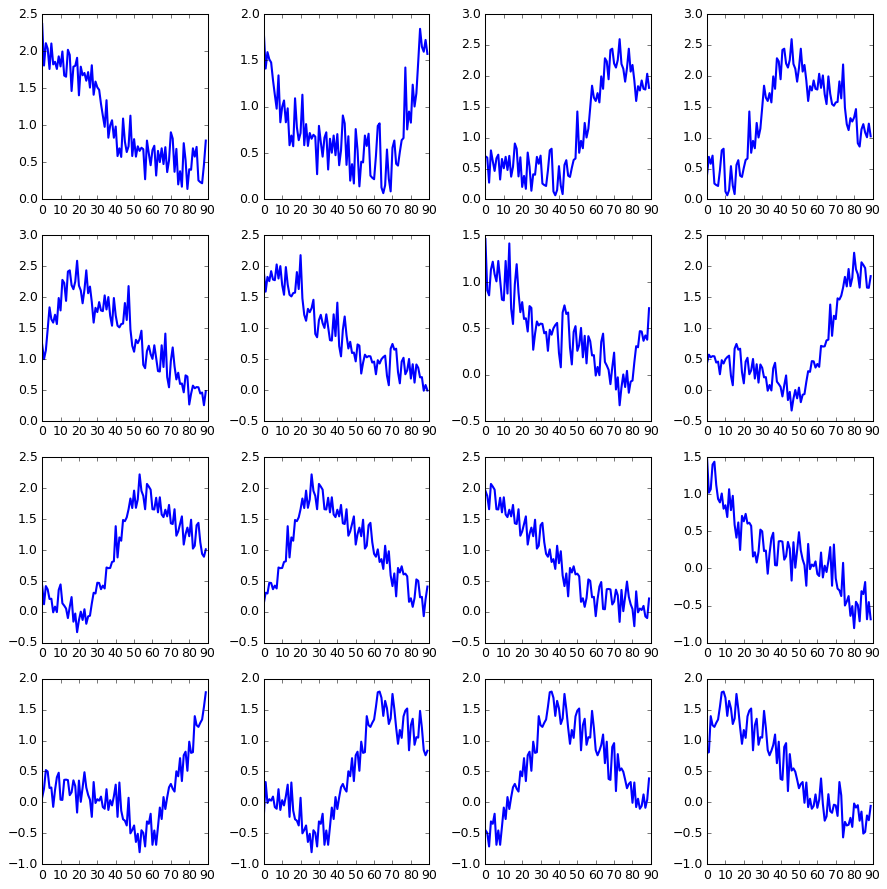

In [7]:
# based on https://github.com/mrahtz/sanger-machine-learning-workshop/blob/master/learn_utils.py
def plot_segments(segments, step):
    plt.figure(figsize=(12,12))
    num_cols = 4
    num_rows = 4
    graph_num = 1
    seg_num = 1

    for _ in range(num_rows):
        for _ in range(num_cols):
            subplt = plt.subplot(num_rows, num_cols, graph_num)
            plt.plot(segments[seg_num])
            graph_num += 1
            seg_num += step

    plt.tight_layout()
    plt.show()

plot_segments(segments, 3)

## Windowing

Note that these segments begin and end on many different values. Since we are going to use cluster centroids based on these segments to reconstruct an expected time series, using segments like these will cause discontinuities in the reconstructed data, since the beginning and ending of each segment are not likely to align. We can remedy this by applying a window function to each segment designed to force the beginning and ending of each segment to zero.

A sinusoidal function of $\pi$ radians (actually 1/2 of a sine wave) can be used to multiply each segment to achieve the desired result. The window function looks like this:

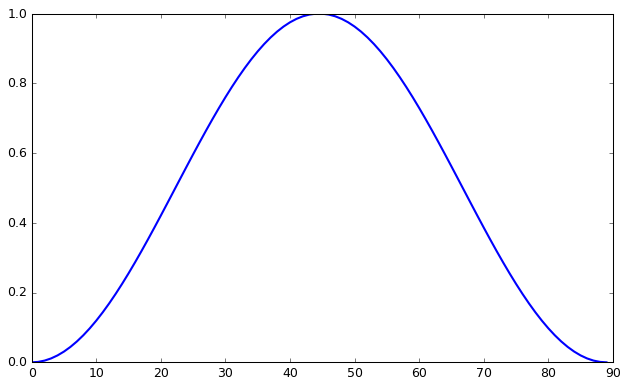

In [8]:
rad = np.linspace(0, np.pi, 90)
window = np.sin(rad)**2
plt.plot(window)

We'll create a method to window a list of segments:

In [9]:
def window_segments(segments, segment_len):
    rad = np.linspace(0, np.pi, segment_len)
    window = np.sin(rad)**2
    windowed_segments = [np.copy(segment) * window for segment in segments]
           
    return windowed_segments

Window our training segments, and display some of them.

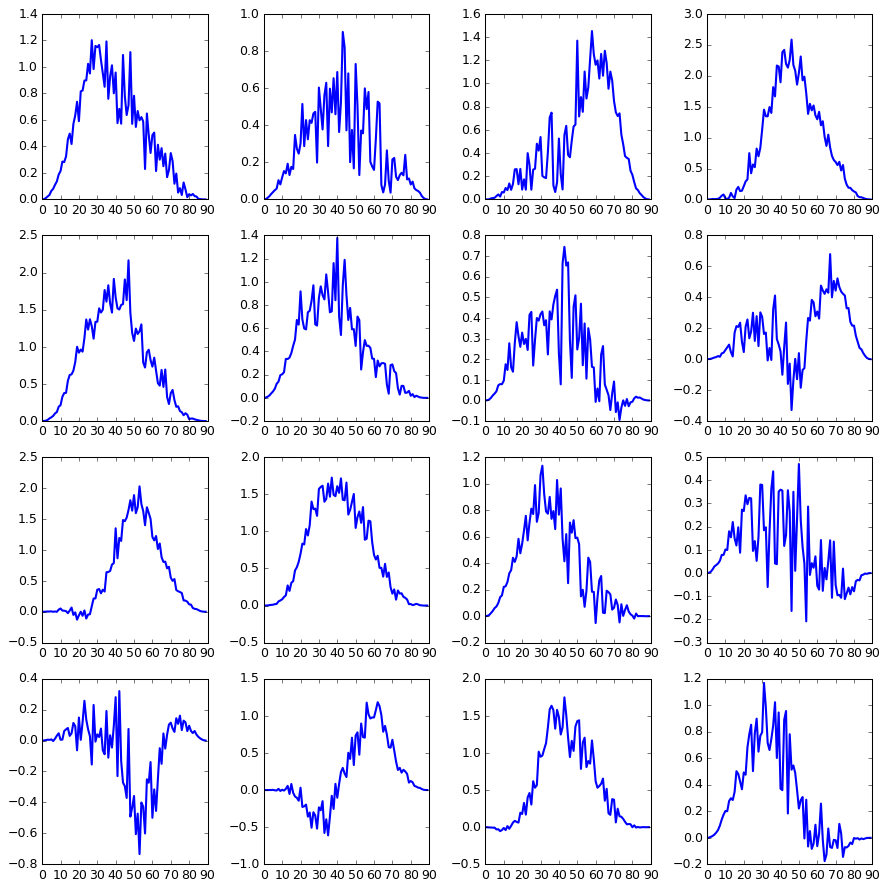

In [10]:
windowed_segments = window_segments(segments, 90)
plot_segments(windowed_segments, 3)

Now we have a collection of segments whose start and end have been forced to zero by the window function. If you want to see what happens if you omit this step, download the live Jupyter notebook and add `windowed_segments = segments` in the next step and then run the notebook.

## Clustering

Now that we have prepared our training segments, we will now cluster them using the [*k-means clustering algorithm*](http://scikit-learn.org/stable/modules/clustering.html#k-means) in the *Scikit-learn* machine learning package. We will specify that the algorithm should find 40 clusters based on experiments with different values of num_clusters.

In [11]:
num_clusters = 40
clusterer = KMeans(n_clusters=num_clusters)
clusterer.fit(windowed_segments)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=40, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Lets examine a few of the resulting cluster centroids, or "typical" segments:

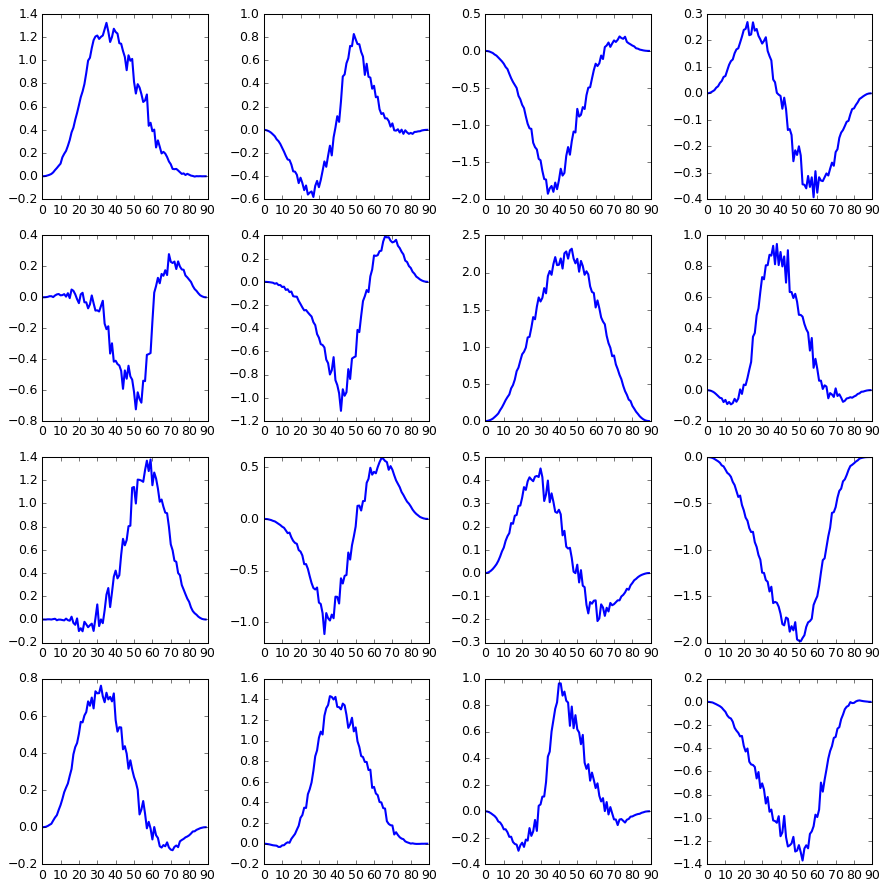

In [12]:
centroids = clusterer.cluster_centers_
plot_segments(centroids,2)

Now we have a collection of "typical" segments from our training data. Let's now apply this collection to our training data as follows:
1. Take the segmented, windowed training data and find the closest centroid to each segment
2. Reconstruct the training time-series by concatenating all of the reconstructed segments together to form a new time-series

This will result in a predicted time-series based on the training data. Subtracting the training time series from the reconstructed time series will result in the *reconstruction error*. 

In [13]:
# based on https://github.com/mrahtz/sanger-machine-learning-workshop/blob/master/learn_utils.py
def reconstruct(data, segment_len, clusterer):
    slide_len = int(segment_len / 2)
    segments = segment(data, segment_len, slide_len)
    windowed_segments = window_segments(segments, segment_len)
    reconstructed = np.zeros(len(data))
    for segment_num, seg in enumerate(windowed_segments):
        # calling seg.reshape(1,-1) is done to avoid a DeprecationWarning from sklearn
        nearest_centroid_idx = clusterer.predict(seg.reshape(1,-1))[0]
        nearest_centroid = np.copy(clusterer.cluster_centers_[nearest_centroid_idx])
        pos = segment_num * slide_len
        reconstructed[pos:pos+segment_len] += nearest_centroid

    return reconstructed

reconstructed_data = reconstruct(train, 90, clusterer)

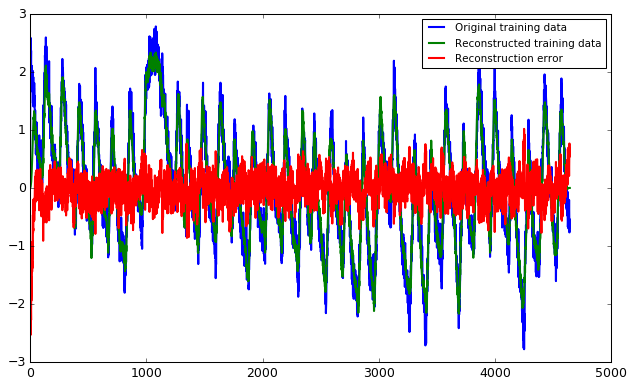

In [14]:
error = reconstructed_data - train
plt.plot(train, label="Original training data")
plt.plot(reconstructed_data, label="Reconstructed training data")
plt.plot(error, label="Reconstruction error")
plt.legend()
plt.show()

Let's get some idea of the maximum reconstruction error, and following the lead of [*Matthew Rahtz*](http://amid.fish/anomaly-detection-with-k-means-clustering), the 98th percentile of reconstruction error:

In [15]:
max_error = np.absolute(error).max()
error_98th_percentile = np.percentile(error, 98)
print('The maxiumum reconstruction error is: {:0.2f}'.format(max_error))
print('The 98th percentile of reconstruction error is: {:0.2f}'.format(error_98th_percentile))

The maxiumum reconstruction error is: 2.53
The 98th percentile of reconstruction error is: 0.48


Not bad, but I think we can do better. In the [next part of this series](https://github.com/mclarknc/Anomaly-Detection/blob/master/Anomaly%20Detection%20-%20Smoothing.ipynb), I will try some techniques to lower our reconstruction error.